In [1]:
import numpy as np
from ipynb.fs.full.Preprocessing import preprocess

# Importing Data

In [2]:
train_x, train_y, test_x, test_y = preprocess(100000)

In [3]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder().fit(train_y.reshape(-1, 1))
train_y=enc.transform(train_y.reshape(-1,1)).toarray()
test_y=enc.transform(test_y.reshape(-1,1)).toarray()

In [4]:
port_x = train_x[0:100]
port_y = train_y[0:100]

# The code of the Neural Network

In [5]:
class Layer:
    def __init__(self, activation_func, size, weights=None,local_fields = None,after_activations=None,bias = 0 ):
        self.activation_func = activation_func #softmax, relu
        self.size =size #number of neurons  
        self.weights = weights
        self.local_fields=local_fields
class Sequential_Model: 
    def __init__(self, input_size, learning_rate,batch_size=12,layer_list = list(),weight_matrix = None,loss_type = "cross_categorical_entropy"):
        self.input_size = input_size
        self.layer_list = layer_list #input node, hidden node or output node   
        self.learning_rate = learning_rate
        self.weight_matrix = weight_matrix
        #self.epoch=100
        self.batch_size = batch_size
        self.loss_type = loss_type
        self.local_field_list = list() 
        self.activation_list = list()
        self.error_list=list()
    def activation(self,induced_local_field,actv_func):
        if actv_func == "relu":
            return max(induced_local_field,0)
        elif actv_func == "sigmoid":# or actv_func == "softmax":
            return 1/(1+np.exp(-induced_local_field))
        elif actv_func == "linear":
            return induced_local_field
        elif actv_func == "softmax":
            return np.exp(induced_local_field)
        else:
            raise ValueError("The activation function was not recognized.")
    def add(self,layer):
        self.layer_list.append(layer)
    def compile(self):
        weight_matrices = list()
        for ind in range(len(self.layer_list)-1):# Initializing the weight matrices
            weight_matrices.append(np.matrix(
                np.random.normal(loc=0.0,
                scale=np.sqrt(2/self.layer_list[ind].size),
                size=(self.layer_list[ind+1].size,
                self.layer_list[ind].size+1)))) #+1 is for bias. so, the rightmost column is the bias weight column.
        
        self.weight_matrix=weight_matrices
    def predict(self,model_input):
        actv = np.vectorize(self.activation)
        estimation = np.transpose(np.matrix(model_input))#,shape=(np.size(model_input),1))
        for ind,matrix in enumerate(self.weight_matrix):
            estimation=matrix*(np.concatenate((estimation,np.ones((1,1))),axis=0))
            estimation = actv(estimation,self.layer_list[ind+1].activation_func)
        if self.layer_list[-1].activation_func=="softmax":
            return estimation/sum(estimation)
    def feed_forward_train(self,model_input):
        self.local_field_list = list() #resetting local field list
        self.activation_list = list()
        actv = np.vectorize(self.activation)
        estimation = np.transpose(np.matrix(model_input))#,shape=(np.size(model_input),1))
        self.activation_list.append(estimation)
        self.local_field_list.append(estimation)
        for ind,matrix in enumerate(self.weight_matrix):
            estimation=matrix*(np.concatenate((estimation,np.ones((1,1))),axis=0))
            self.local_field_list.append(estimation)
            estimation = actv(estimation,self.layer_list[ind+1].activation_func)
            self.activation_list.append(estimation)
        if self.layer_list[-1].activation_func=="softmax":
            return estimation/sum(estimation)
        

        return estimation
    def loss_calc(self,est,truth):
        
        if self.loss_type=="cross_categorical_entropy":
            return np.sum(np.array(truth * -np.log(est)), axis=-1, keepdims=False)
        elif self.loss_type=="mean_squared_error":
            return (np.norm(est-truth)**2)/len(truth)
        else:
            raise ValueError("Loss type not recognized.")
    def gradient(self,input,activation_func):
        if activation_func == "relu":
            return 1*(input>=0)
        elif activation_func == "linear":
            return 1
        return 0
    def train(self,X,y,epoch):
        
        for _ in range(epoch):
            try:
                self.error_list.append(error)
            except:
                pass
            for _ in range(len(X)//self.batch_size):
                indices = np.random.choice(np.shape(X)[0],self.batch_size,replace=False)
                mini_x,mini_y = X[indices,:], y[indices,:]
                error=0
                for ind,entry in enumerate(mini_x):
                    model_out = self.feed_forward_train(entry)
                    error += self.loss_calc(model_out,mini_y[ind])
                vec_loss = model_out-mini_y.transpose()
                #error /= self.batch_size
                
                self.backpropagate(error,vec_loss)
    def backpropagate(self,error,vec_loss):
        list_of_deltas = [vec_loss]
        for ind in reversed(range(len(self.layer_list)-1)):
            A = self.weight_matrix[ind][:,:-1].transpose()*list_of_deltas[-1]
            B = self.gradient(self.local_field_list[ind],self.layer_list[ind].activation_func)
            list_of_deltas.append(np.multiply(A,B))
        list_of_deltas.reverse()
        for ind in range(len(self.weight_matrix)):
            delta = np.matrix(list_of_deltas[ind+1])
            actv = np.matrix(self.activation_list[ind])
            update = self.learning_rate*(delta*actv.transpose())
            self.weight_matrix[ind][:,:-1] -= update.astype('float32')
            self.weight_matrix[ind][:,-1] -= self.learning_rate*delta
            
            
            #self.weight_matrix[ind][:,-1] += self.learning_rate*(np.matrix(self.activation_list[ind-1])*np.transpose(list_of_deltas[ind]))
            #self.weight_matrix[ind][:,:-1] += self.learning_rate*(np.transpose(np.matrix(self.weight_matrix[:,:-1])))*(np.matrix(self.activation_list[ind-1])*np.transpose(list_of_deltas[ind]))


In [6]:
model = Sequential_Model(input_size=12,loss_type = "cross_categorical_entropy",learning_rate=0.001,batch_size=1)
model.add(Layer(activation_func="linear", size=12))
model.add(Layer(activation_func="relu",size=8))
model.add(Layer(activation_func="softmax",size=3))
model.compile()

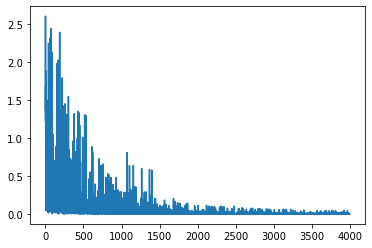

In [7]:
import matplotlib.pyplot as plt
model.train(port_x,port_y,epoch=4000)
plt.plot(model.error_list)

In [8]:
counter = 0
for ind,row in enumerate(test_x):
    pos = np.argmax(model.predict(row),axis=0)
    if np.argmax(test_y,axis=1).tolist()[ind]==np.array(pos).squeeze():
        counter +=1

print(counter*100/len(test_y))

80.56


# The Experimental